In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import muse.supplier as spr
import muse.processor as pcr
import muse.model2 as mdl
import muse.trainer as trn
import muse.visualizer as vis

import warnings
warnings.filterwarnings("ignore")

In [2]:
### ===== Hyperparameters ===== ###

mdl_name = 'vae3_melody'
instrument = 'Piano'
filepath = "./../input/haydn/"
song_len = 200*4
stride = 200
epochs = 1000
learning_rate = 0.001

seed_load = np.random.randint(0,999999999)
seed_load = 21718471
seed_model = np.random.randint(0,999999999)
device = trn.get_device()

In [3]:
### ===== Data Preprocessing ===== ###

all_midis, filenames = pcr.get_midis(filepath) # load all .midi files
Corpus, instru2corpus = pcr.extract_notes_batch(all_midis) # extract all notes and sort by instrument
Corpus = pcr.remove_rare(Corpus, 0)[0] # remove notes that occur for less than $thre$ times
Corpus, fmap, rmap = pcr.get_map(Corpus) # get forward-map and reverse-map from corpus
instru2corpus = pcr.remove_short(instru2corpus) # remove songs that are too short
instru2corpus = pcr.upsample_batch(instru2corpus) # upsample notes according to multiples of duration
X_train, X_val, _, _ = pcr.train_test_split(instru2corpus, instrument, fmap, song_len, stride,\
                                                                                  seed=seed_load)
X_train, X_val = pcr.batchify(X_train), pcr.batchify(X_val) # reshape and turn into tensor
classes = len(set(Corpus)) # get number of unique keys

In [4]:
### ===== Training Loop ===== ###

def train_model(model, device, mdl_name,
                train_loader, val_loader, 
                lr, seeds, epochs, 
                eepoch=10, epoch_start=0,
                lda0=1, lda1=1, lda2=1,
                train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                stdlog=[],
                save=True, load=False, mdl_load=''):
    
    # get loss function 
    criterion1 = nn.MSELoss()
    criterion2 = nn.CrossEntropyLoss()
    
    # get optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # load model
    if load:
        model, train_losses, val_losses, train_acc, val_acc, epoch_start, seeds = trn.load_model(mdl_load, model, device)
        
    # set parameters
    if type(lda0) != np.ndarray: lda0 = np.ones(epochs)*lda0
    if type(lda1) != np.ndarray: lda1 = np.ones(epochs)*lda1
    if type(lda2) != np.ndarray: lda2 = np.ones(epochs)*lda2

    # training loop
    for epoch in range(epoch_start, epoch_start+epochs):
        
        # set std
        e = epoch-epoch_start
        if stdlog != []:
            model.std = stdlog[e]

        # train model
        model.train()
        
        batch_losses = []
        for batch_idx, batch_data in enumerate(train_loader):
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            recons, mu, logvar, prob = model(batch_data)
            
            # calculate loss
            if lda1.all() != 0:
                l = lda0[e]*criterion1(recons, batch_data) + lda1[e]*criterion2(prob, batch_data.squeeze().long()) + lda2[e]*trn.KL(mu, logvar)
            else:
                l = lda0[e]*criterion1(recons, batch_data) + lda2[e]*trn.KL(mu, logvar)
            l.backward()
            optimizer.step()
            batch_losses.append(l.item())
            
        train_losses.append(np.mean(batch_losses))
        train_acc.append(trn.accuracy(recons.view(-1), batch_data.view(-1)))

        # validate model
        model.eval()
        
        batch_losses = []
        for batch_idx, batch_data in enumerate(val_loader):
            batch_data = batch_data.to(device)
            recons, mu, logvar, prob = model(batch_data)
            
            # calculate loss
            if lda1.all() != 0:
                l = lda0[e]*criterion1(recons, batch_data) + lda1[e]*criterion2(prob, batch_data.squeeze().long()) + lda2[e]*trn.KL(mu, logvar)
            else:
                l = lda0[e]*criterion1(recons, batch_data) + lda2[e]*trn.KL(mu, logvar)
            batch_losses.append(l.item())
            
        val_losses.append(np.mean(batch_losses))
        val_acc.append(trn.accuracy(recons.view(-1), batch_data.view(-1)))
        
        # print loss, accuracy
        if epoch % eepoch == 0:
            
            print('Epoch: {}\t TLoss: {:.6f}\t VLoss: {:.6f}\t TACC: {:.2f}\t VACC: {:.2f}'\
                  .format(epoch, train_losses[-1], val_losses[-1], train_acc[-1], val_acc[-1]))
   
        # save model
        if save:
            state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
              'train_losses': train_losses, 'val_losses':val_losses, 
              'train_acc':train_acc, 'val_acc':val_acc, 'seeds': seeds}
            torch.save(state, './models/'+mdl_name+'.pt')
        
    return model, train_losses, val_losses, train_acc, val_acc

Epoch: 0	 TLoss: 282.939765	 VLoss: 162.017806	 TACC: 0.03	 VACC: 0.03
Epoch: 100	 TLoss: 78.057540	 VLoss: 125.593393	 TACC: 0.06	 VACC: 0.04
Epoch: 200	 TLoss: 68.064937	 VLoss: 132.937479	 TACC: 0.05	 VACC: 0.04
Epoch: 300	 TLoss: 61.866342	 VLoss: 133.116454	 TACC: 0.08	 VACC: 0.04
Epoch: 400	 TLoss: 58.973898	 VLoss: 131.127662	 TACC: 0.07	 VACC: 0.04
Epoch: 500	 TLoss: 57.629667	 VLoss: 140.294736	 TACC: 0.07	 VACC: 0.03
Epoch: 600	 TLoss: 57.488077	 VLoss: 146.408268	 TACC: 0.09	 VACC: 0.03
Epoch: 700	 TLoss: 56.188041	 VLoss: 145.037660	 TACC: 0.11	 VACC: 0.04
Epoch: 800	 TLoss: 54.324480	 VLoss: 143.518523	 TACC: 0.09	 VACC: 0.05
Epoch: 900	 TLoss: 56.025191	 VLoss: 139.650288	 TACC: 0.08	 VACC: 0.03
Epoch: 1000	 TLoss: 53.755986	 VLoss: 148.356292	 TACC: 0.09	 VACC: 0.05
Epoch: 1100	 TLoss: 53.525275	 VLoss: 144.304340	 TACC: 0.09	 VACC: 0.04
Epoch: 1200	 TLoss: 52.967449	 VLoss: 152.020227	 TACC: 0.10	 VACC: 0.04
Epoch: 1300	 TLoss: 53.400586	 VLoss: 138.656499	 TACC: 0.10	 

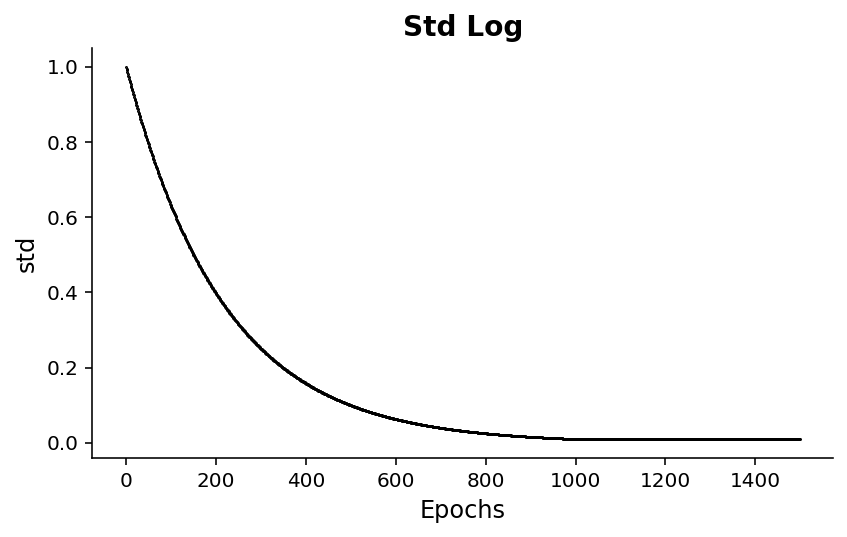

<Figure size 432x288 with 0 Axes>

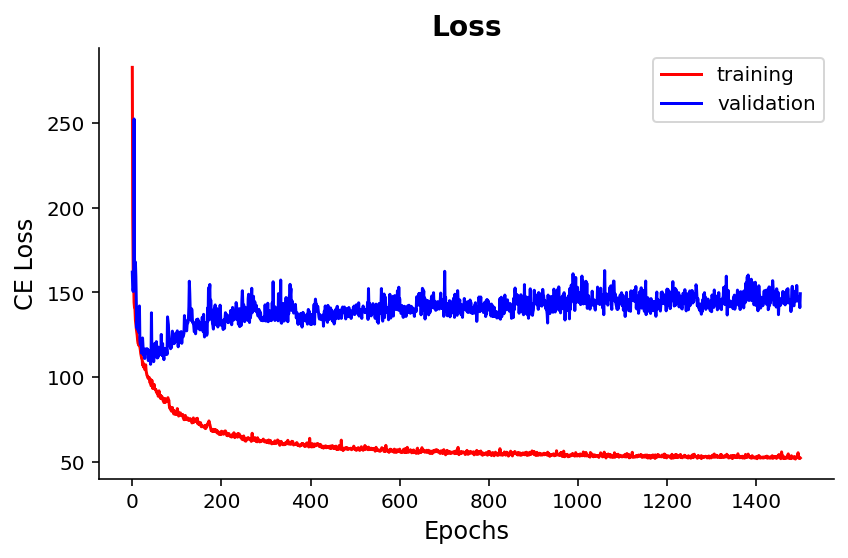

<Figure size 432x288 with 0 Axes>

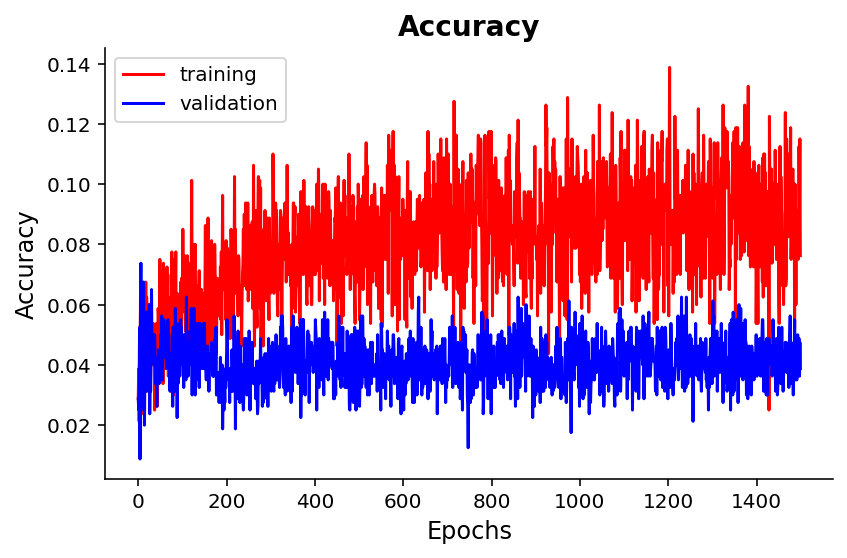

<Figure size 432x288 with 0 Axes>

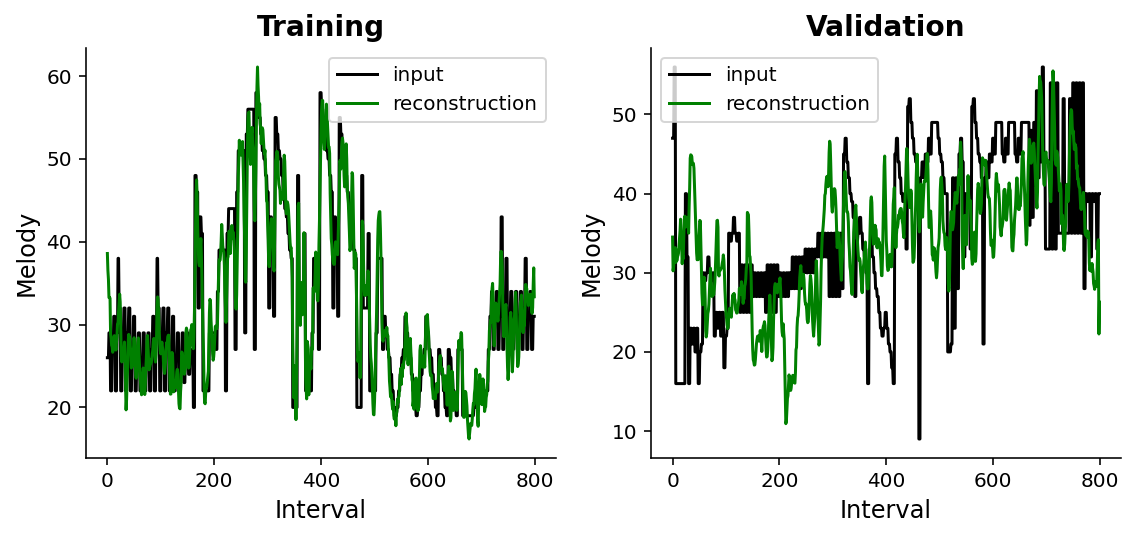

<Figure size 432x288 with 0 Axes>

In [5]:
### ===== Train Model for Melody using MSELoss ===== ###

seed_model = np.random.randint(0,999999999)
seed_model = 527758681 
torch.manual_seed(seed_model)

model = mdl.cnn_varautoencoder(1, song_len//200, classes, std=1.0)
model.float()
model.to(device)

try: 
    stdlog = np.append(np.geomspace(1, 0.01, 1000), np.ones(500)*0.01)
    model_melody, train_losses_m, val_losses_m, train_acc_m, val_acc_m = train_model(model, device, mdl_name+'_MSE',
                   X_train, X_val,
                   learning_rate, [seed_load, seed_model], 1500,
                   eepoch=100,
                   lda0=1, lda1=0, lda2=1,
                   stdlog=stdlog,
                   train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                   save=True, load=False)
    
    vis.plot_stdlog(stdlog, './figures/vae3_melody_MSE_stdlog.png')
    vis.plot_train_val_loss(train_losses_m, val_losses_m, './figures/vae3_melody_MSE_loss.png', ylabel='CE Loss')
    vis.plot_train_val_loss(train_acc_m, val_acc_m, './figures/vae3_melody_MSE_acc.png', ylabel='Accuracy', title='Accuracy')
    _ = vis.plot_train_val_sample(model_melody, X_train[0], X_val[0], './figures/vae3_melody_MSE_sample.png')
    
except KeyboardInterrupt:
    print('Training terminated.')

Epoch: 1500	 TLoss: 37.883047	 VLoss: 76.698488	 TACC: 0.07	 VACC: 0.05
Epoch: 1600	 TLoss: 62.315298	 VLoss: 181.856829	 TACC: 0.09	 VACC: 0.03
Epoch: 1700	 TLoss: 106.602524	 VLoss: 472.309488	 TACC: 0.12	 VACC: 0.04
Epoch: 1800	 TLoss: 192.057161	 VLoss: 1083.102130	 TACC: 0.13	 VACC: 0.04
Epoch: 1900	 TLoss: 354.827031	 VLoss: 2707.651441	 TACC: 0.18	 VACC: 0.05
Epoch: 2000	 TLoss: 836.915373	 VLoss: 7303.387509	 TACC: 0.15	 VACC: 0.04
Epoch: 2100	 TLoss: 2061.067333	 VLoss: 20611.921494	 TACC: 0.10	 VACC: 0.04
Epoch: 2200	 TLoss: 4474.883508	 VLoss: 46759.652937	 TACC: 0.10	 VACC: 0.04
Epoch: 2300	 TLoss: 11099.050455	 VLoss: 111867.658542	 TACC: 0.16	 VACC: 0.05
Epoch: 2400	 TLoss: 26209.308153	 VLoss: 288688.682608	 TACC: 0.10	 VACC: 0.04
Epoch: 2500	 TLoss: 65124.981449	 VLoss: 723991.778167	 TACC: 0.15	 VACC: 0.03
Epoch: 2600	 TLoss: 68996.418126	 VLoss: 740098.274778	 TACC: 0.09	 VACC: 0.04
Epoch: 2700	 TLoss: 57806.051761	 VLoss: 709975.209358	 TACC: 0.17	 VACC: 0.05
Epoch: 

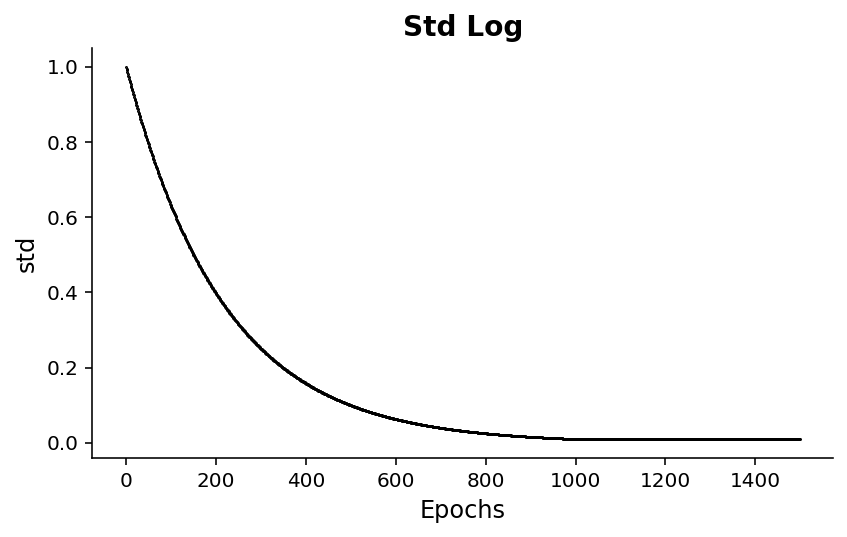

<Figure size 432x288 with 0 Axes>

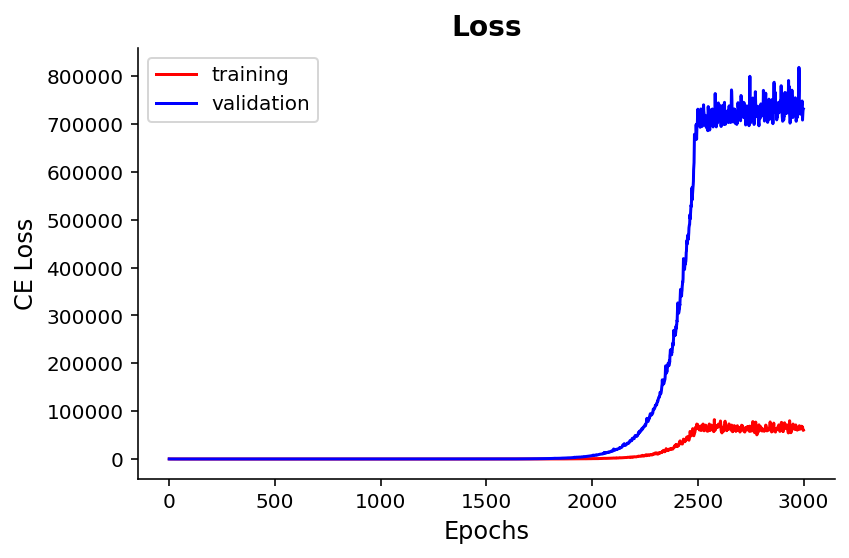

<Figure size 432x288 with 0 Axes>

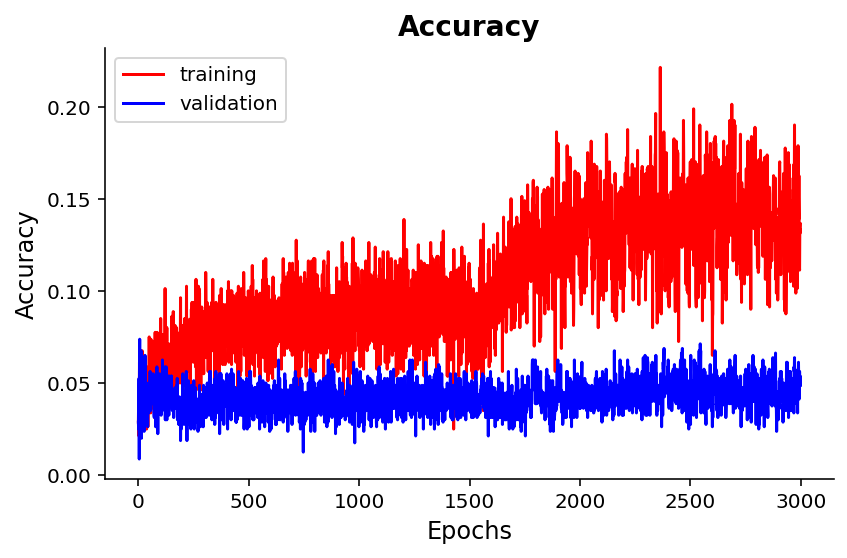

<Figure size 432x288 with 0 Axes>

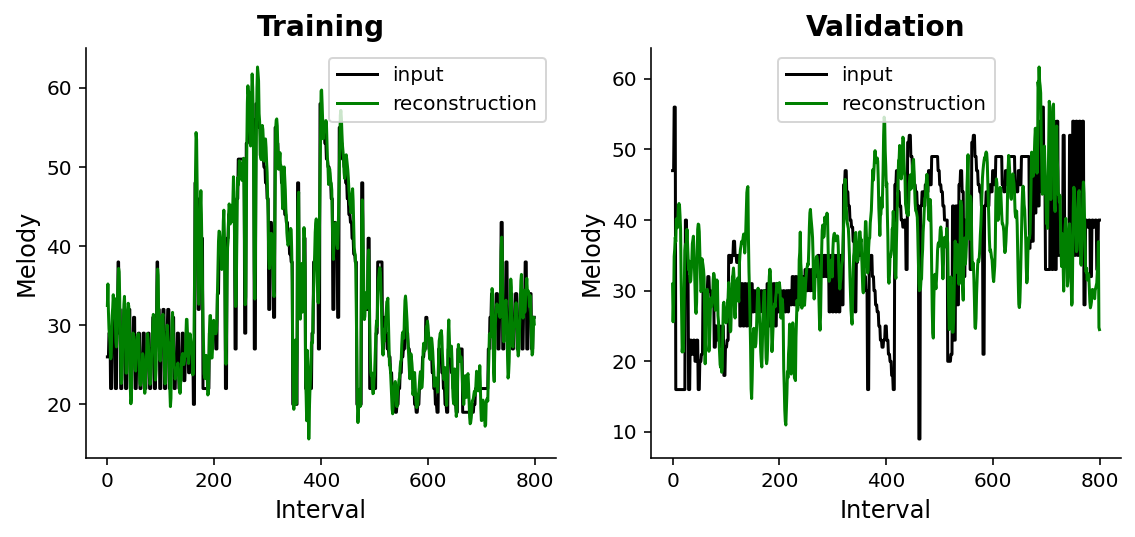

<Figure size 432x288 with 0 Axes>

In [6]:
### ===== Train Model for Melody using CELoss ===== ###

seed_model = np.random.randint(0,999999999)
seed_model = 527758681 
torch.manual_seed(seed_model)

model = mdl.cnn_varautoencoder(1, song_len//200, classes, std=1.0)
model.float()
model.to(device)

try: 
    stdlog = np.append(np.geomspace(1, 0.01, 1000), np.ones(500)*0.01)
    model_melody, train_losses_m, val_losses_m, train_acc_m, val_acc_m = train_model(model, device, mdl_name+'_CE',
                   X_train, X_val,
                   learning_rate, [seed_load, seed_model], 1500,
                   eepoch=100,
                   lda0=0, lda1=1, lda2=1,
                   stdlog=stdlog,
                   train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                   save=True, load=True, mdl_load=mdl_name+'_MSE')
    
    vis.plot_stdlog(stdlog, './figures/vae3_melody_CE_stdlog.png')
    vis.plot_train_val_loss(train_losses_m, val_losses_m, './figures/vae3_melody_CE_loss.png', ylabel='CE Loss')
    vis.plot_train_val_loss(train_acc_m, val_acc_m, './figures/vae3_melody_CE_acc.png', ylabel='Accuracy', title='Accuracy')
    _ = vis.plot_train_val_sample(model_melody, X_train[0], X_val[0], './figures/vae3_melody_CE_sample.png')
    
except KeyboardInterrupt:
    print('Training terminated.')